# Example using an AmeriFlux site and the ``flux-data-qaqc`` Python module

This flux tower site is in Ohio near Lake Erie in a crop (wheat and soy) setting near a marsh. For more information on the site visit AmeriFlux here: [https://ameriflux.lbl.gov/sites/siteinfo/US-CRT#overview](https://ameriflux.lbl.gov/sites/siteinfo/US-CRT#overview)

In [1]:
%matplotlib inline
import os
import utm
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import pyproj
from fluxdataqaqc import Data
from rasterio.plot import show

In [2]:
import sys
sys.path.append("../../scripts/") 
import ffp
import calc_footprint_FFP_climatology as oldffp
import footprint_funcs as ff

# Read in data using ``flux-data-qaqc``, resample to hourly 

Note that some wind variables are not excplicitly required by ``flux-data-qaqc``, i.e. not automatically referenced in the config and objects, to load them here we added the ``load_all_vars`` metadata option and refer to them by their respective names in the climate data file "AMF_US-CRT_BASE_HH_3-5.csv". In this case these variables are Monin-Obukhov length "MO_LENGTH", standard deviation of lateral velocity fluctuations "V_SIGMA", and friction velocity "USTAR". 

In [3]:
stat_data = Data('US-CRT_config.ini')

stat_data.variables['MO_LENGTH'] = 'MO_LENGTH'
stat_data.variables['USTAR'] = 'USTAR'
stat_data.variables['V_SIGMA'] = 'V_SIGMA'

df = stat_data.df.rename(columns=stat_data.inv_map)
df = df.resample('h').mean()

In [4]:
df[['wd','ws','MO_LENGTH','USTAR','V_SIGMA']].head()

,wd,ws,MO_LENGTH,USTAR,V_SIGMA
date,,,,,
2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
2011-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN
2011-01-01 02:00:00,254.7010,3.11869,69.337979,0.27374,1.375590
2011-01-01 03:00:00,232.3775,4.27658,76.689723,0.27932,0.979255
2011-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN


# Convert station lat/lon to local UTM for georeferencing

In [5]:
latitude = stat_data.latitude
longitude = stat_data.longitude
station_coord = (latitude, longitude)
# get EPSG code from lat,long, convert to UTM https://epsg.io/32617
#EPSG=32700-np.round((45+latitude)/90.0)*100+np.round((-183+longitude)/6.0)
EPSG = 5070
#utm_coords = utm.from_latlon(latitude, longitude)

transformer = pyproj.Transformer.from_crs("EPSG:4326", f"EPSG:{EPSG:.0f}")
(station_y, station_x) = transformer.transform(*station_coord)
station = stat_data.site_id
(station_y, station_x)

(1043351.7812768925, 2138906.4596680813)

In [6]:
transformer.target_crs

<Projected CRS: EPSG:5070>
Name: NAD83 / Conus Albers
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: Conus Albers
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# Estimate remaining parameters and create daily footprint rasters with hourly footprints as bands

A few assumptions, the canopy height of 0.2 meters is constant, this site according to the owners is winter wheat and soybean rotation. Displacement height was not given but estimated for cropland as $d = 10^{0.979 \log_{10} hc - 0.154}$. Also, planetary boundary layer height was assigned as 2 km. Roughness length was also estimated as $0.123 h_c$. The footprints in this example are only calculated for hours between 7 AM and 8 PM, this alongwith footprint array domain, resolution, and other options are all easily adjustable using the arguments to the Kljun et al. footprint function. 

In [8]:
h_c = 0.2 #Height of canopy [m]
# Estimated displacement height [m]
d = 10**(0.979* np.log10(h_c) - 0.154)
d

0.14511368335719918

Date: 2011 01 03




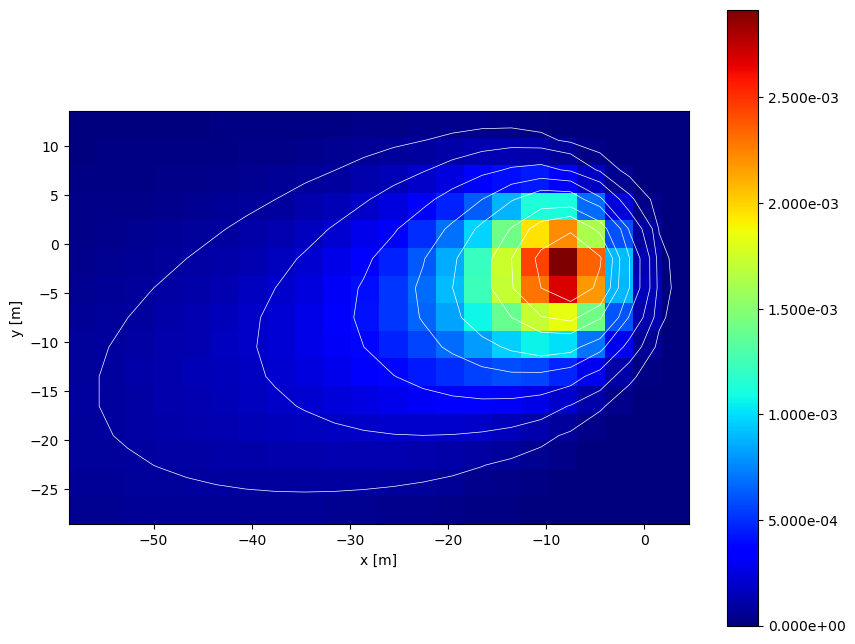

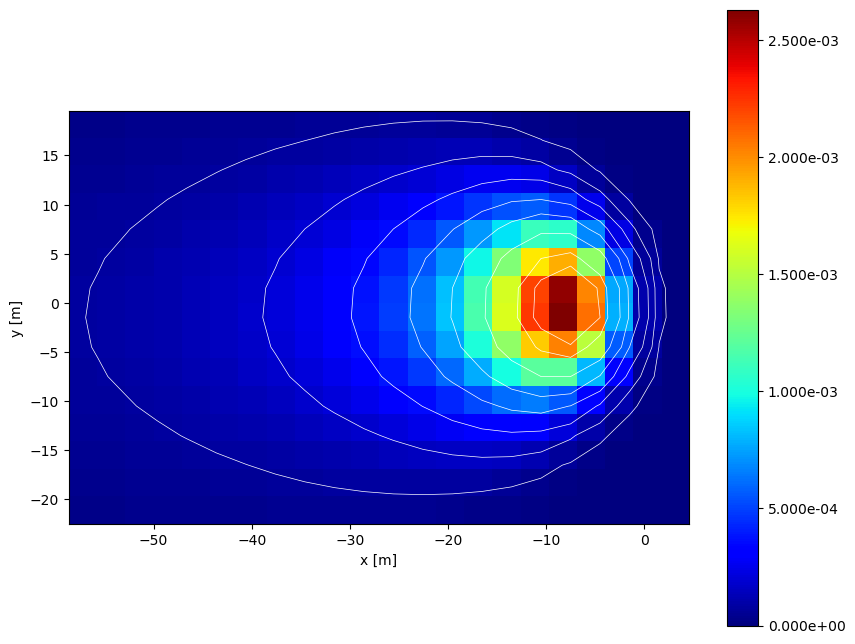

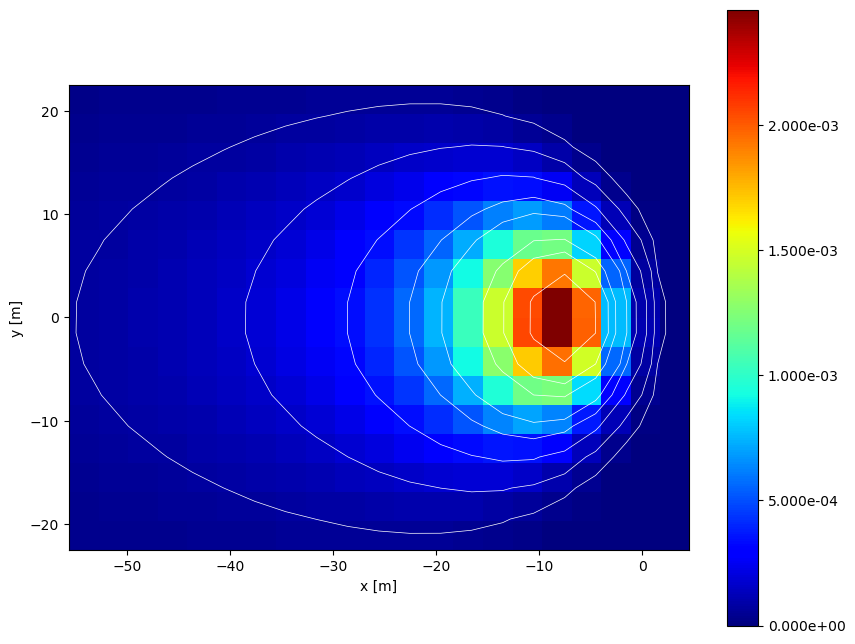

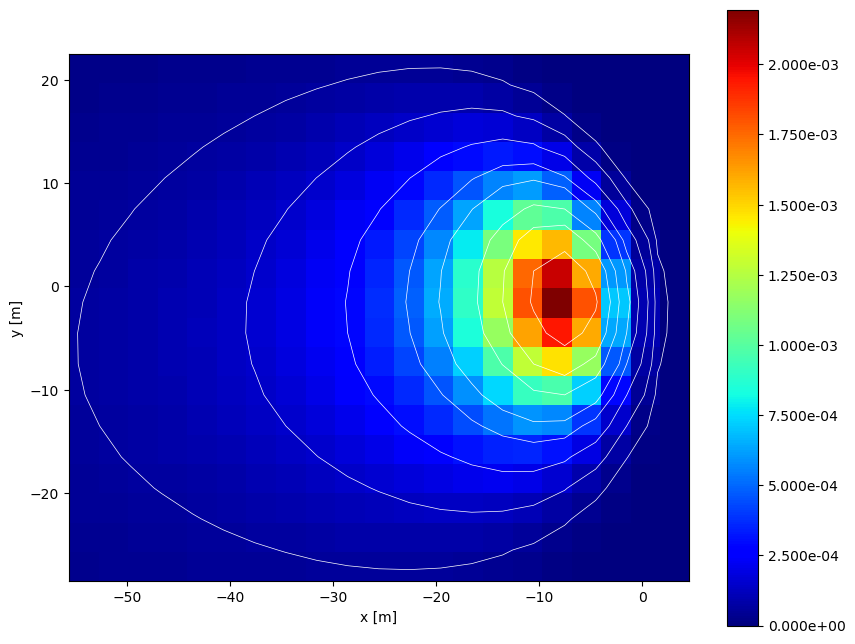

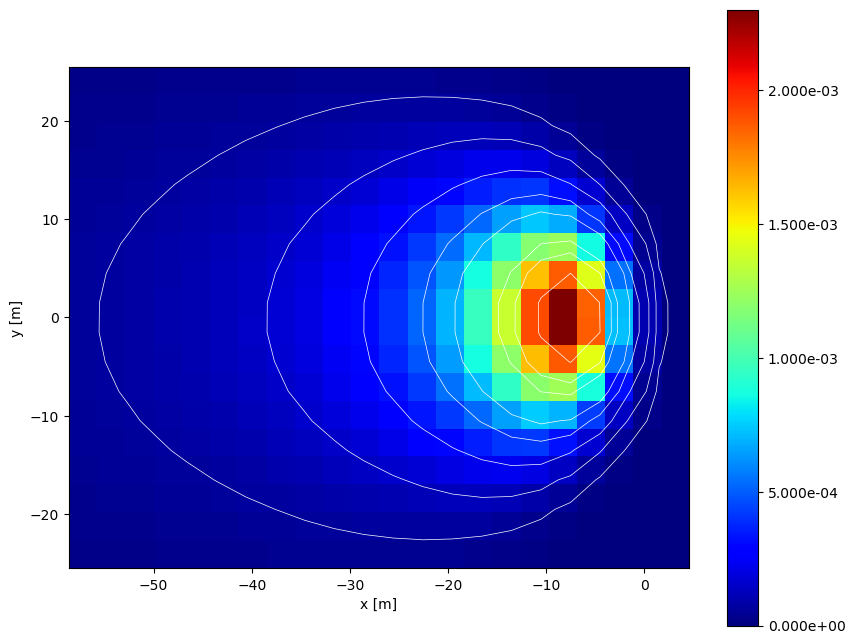

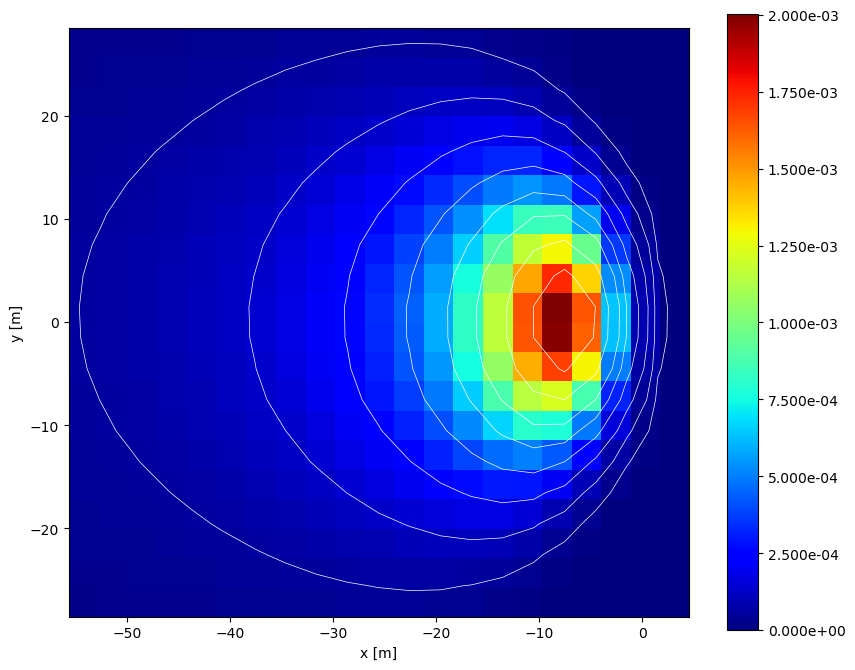

In [9]:
#Other model parameters
zm_s = 2. #Measurement height [m] from AMF metadata
h_s = 2000. #Height of atmos. boundary layer [m] - assumed
dx = 3. #Model resolution [m]
origin_d = 200. #Model bounds distance from origin [m]
# from 7 AM to 8 PM only, modify if needed
start_hr = 9
end_hr = 14
hours = np.arange(start_hr,end_hr+1)

date = df.index[50]
#Subset dataframe to only values in day of year
print(f'Date: {date:%Y %m %d}')
temp_df = df.loc[(df.index.dayofyear == df.index[60].dayofyear)&(df.index.year == df.index[60].year)]
    
new_dat = None

for indx, t in enumerate(hours):
    
    band = indx + 1
    #print(f'Hour: {t}')

    try:
        temp_line = temp_df.loc[temp_df.index.hour == t,:]

        #Calculate footprint
        temp_ffp = ffp.ffp_climatology(domain=[-origin_d,origin_d,-origin_d,origin_d],dx=dx,dy=dx,
                                zm=zm_s-d, h=h_s, rs=None, z0=h_c*.123, 
                                ol=temp_line['MO_LENGTH'].values,sigmav=temp_line['V_SIGMA'].values,
                                ustar=temp_line['USTAR'].values, #umean=temp_line['ws'].values,
                                wind_dir=temp_line['wd'].values,
                                crop=1,fig=1,verbosity=1)
    except Exception as e:
        print(e)

In [10]:
#Other model parameters
zm_s = 2. #Measurement height [m] from AMF metadata
h_s = 2000. #Height of atmos. boundary layer [m] - assumed
dx = 3. #Model resolution [m]
origin_d = 200. #Model bounds distance from origin [m]
# from 7 AM to 8 PM only, modify if needed
start_hr = 7
end_hr = 20
hours = np.arange(start_hr,end_hr+1)

#Loop through each day in the dataframe
for date in df.index.date:
    
    #Subset dataframe to only values in day of year
    print(f'Date: {date}')
    temp_df = df[df.index.date == date]
        
    new_dat = None
    
    for indx,t in enumerate(hours):
        
        band = indx + 1
        print(f'Hour: {t}')

        try:
            temp_line = temp_df.loc[temp_df.index.hour == t,:]

            #Calculate footprint
            temp_ffp = ffp.ffp_climatology(domain=[-origin_d,origin_d,-origin_d,origin_d],dx=dx,dy=dx,
                                    zm=zm_s-d, h=h_s, rs=None, z0=h_c*.123, 
                                    ol=temp_line['MO_LENGTH'].values,sigmav=temp_line['V_SIGMA'].values,
                                    ustar=temp_line['USTAR'].values, #umean=temp_line['ws'].values,
                                    wind_dir=temp_line['wd'].values,
                                    crop=0,fig=0,verbosity=0)
            ####verbosoity=2 prints out errors; if z0 triggers errors, use umean
            #    print(zm_s-d)

            f_2d = np.array(temp_ffp.output['fclim_2d'])
            x_2d = np.array(temp_ffp.output['x_2d']) + station_x
            y_2d = np.array(temp_ffp.output['y_2d']) + station_y
            f_2d = f_2d*dx**2

            #Calculate affine transform for given x_2d and y_2d
            affine_transform = ff.find_transform(x_2d,y_2d)

            #Create data file if not already created
            if new_dat is None:
                out_f = f'./output/a{date}_{station}.tif'
                print(f_2d.shape)
                new_dat = rasterio.open(out_f,'w',driver='GTiff',dtype=rasterio.float64,
                                        count=len(hours),height=f_2d.shape[0],width=f_2d.shape[1],
                                        transform=affine_transform,
                                        crs=transformer.target_crs,
                                        nodata=0.00000000e+000)

        except Exception as e:

            print(f'Hour {t} footprint failed, band {band} not written.')
            print(e)
            temp_ffp = None

            continue

        #Mask out points that are below a % threshold (defaults to 90%)
        f_2d = ff.mask_fp_cutoff(f_2d)

        #Write the new band
        new_dat.write(f_2d,indx+1)

        #Update tags with metadata
        tag_dict = {'hour':f'{t*100:04}',
                    'wind_dir':temp_line['wd'].values,
                    'total_footprint':np.nansum(f_2d)}

        new_dat.update_tags(indx+1,**tag_dict)
    
    #Close dataset if it exists
    try:
        new_dat.close()
    except:
        continue
    
    print()
    
    # for esample just create a single day and exit
    break

Date: 2011-01-01
Hour: 7
(134, 134)
Hour: 8
Hour: 9
Hour: 10
Hour: 11
Hour: 12
Hour 12 footprint failed, band 6 not written.
min() arg is an empty sequence
Hour: 13
Hour: 14
Hour: 15
Hour 15 footprint failed, band 9 not written.
min() arg is an empty sequence
Hour: 16
Hour 16 footprint failed, band 10 not written.
min() arg is an empty sequence
Hour: 17
Hour 17 footprint failed, band 11 not written.
min() arg is an empty sequence
Hour: 18
Hour: 19
Hour: 20



# View footprint raster

First plot shows georeferenced (UTM zone 17) footprint (first bad at 7:00 AM) and the plot below shows a different hour, the third plot shows the daily average using matplotlib. Not the second two plots are not georefenced and the axes are in pixel count.

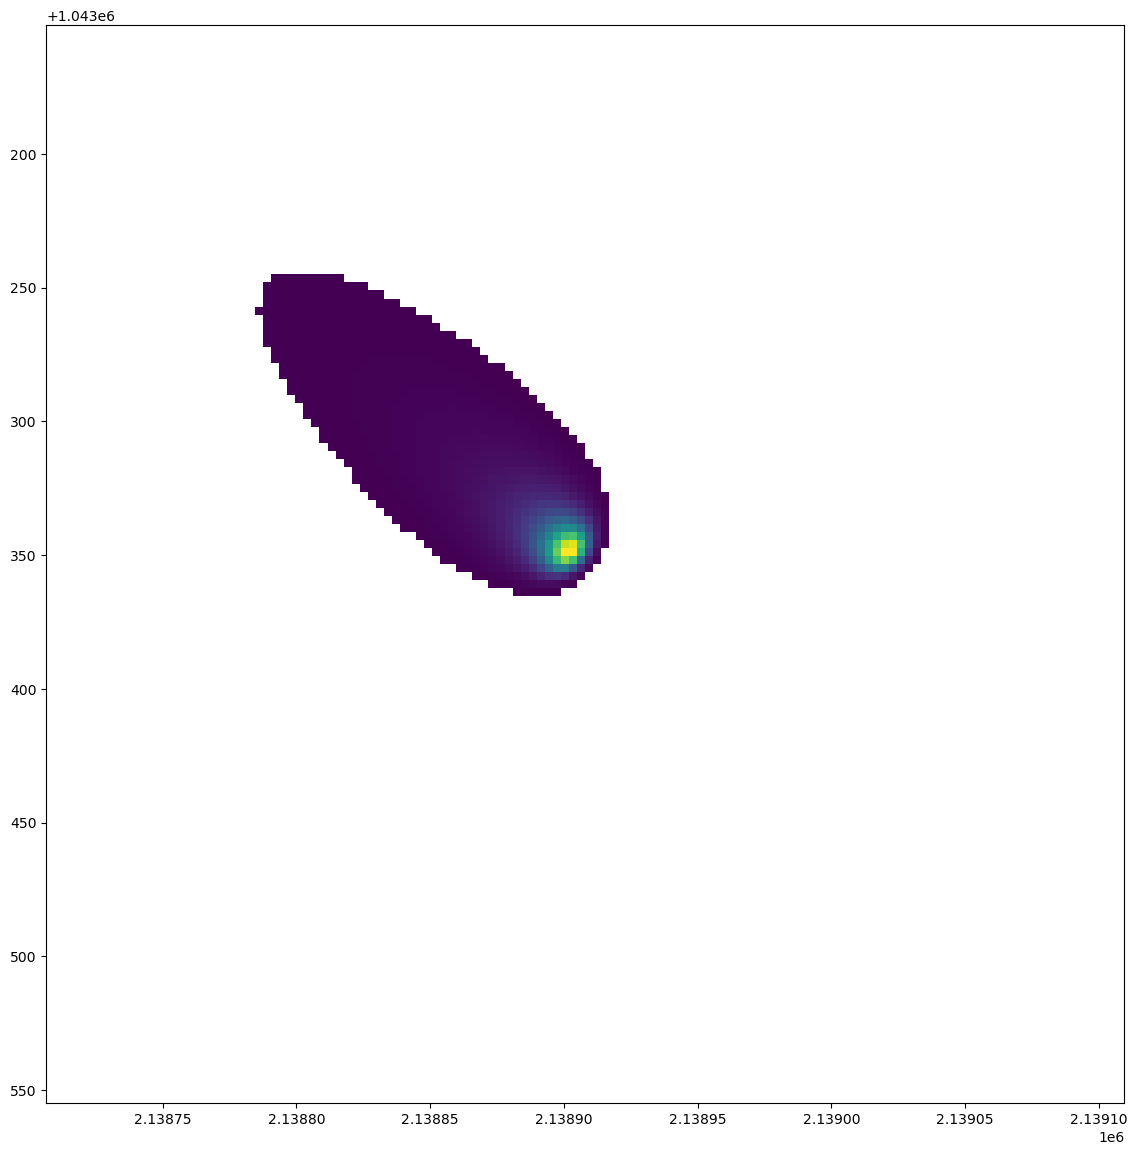

<Axes: >

In [11]:
plt.figure(figsize=(14,14))
src = rasterio.open("./output/a2011-01-01_US-CRT.tif")
show(src)

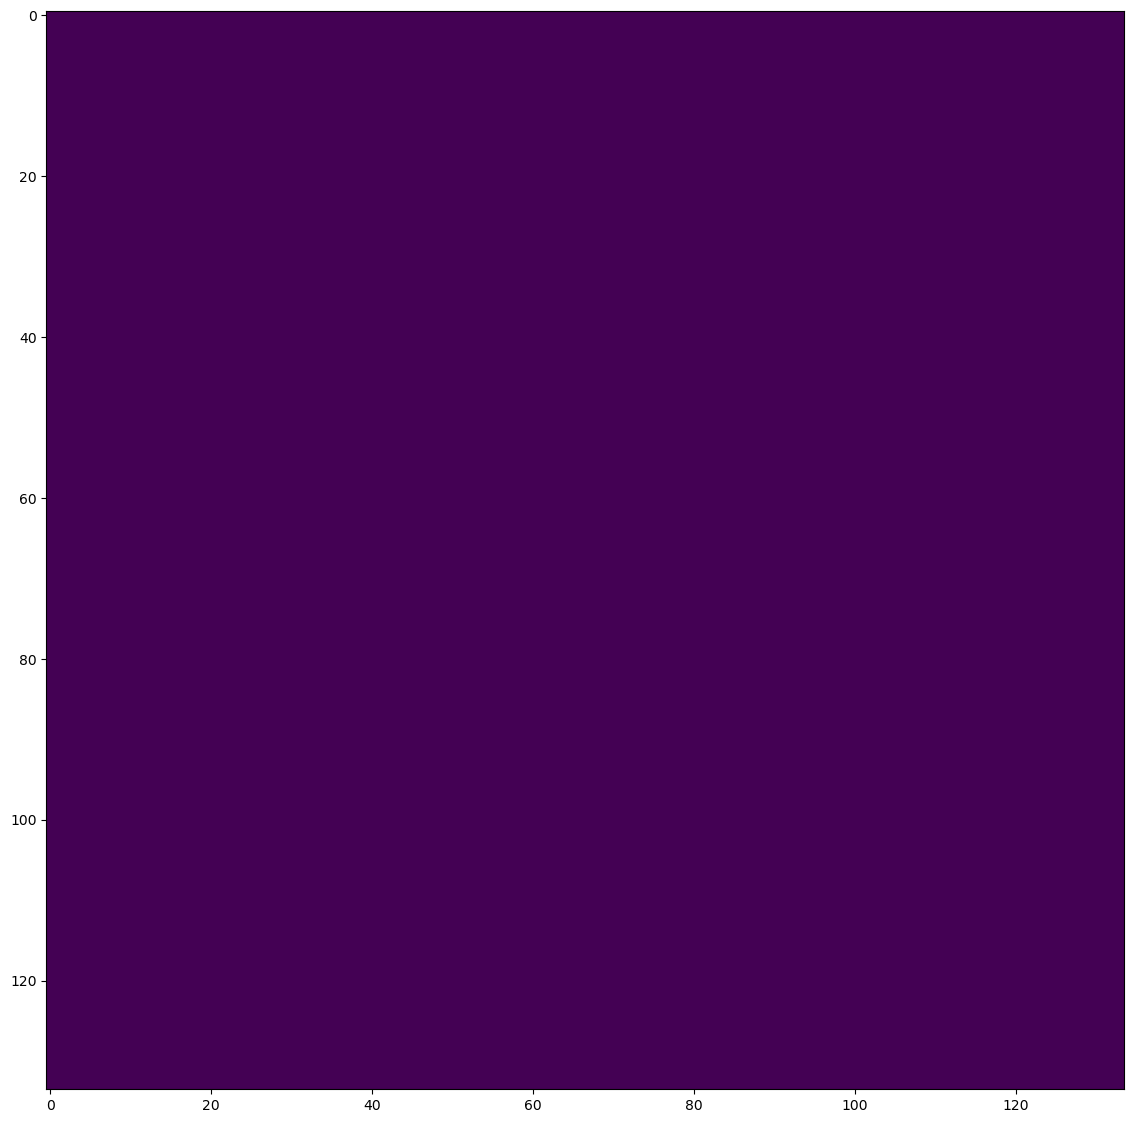

<Axes: >

In [12]:
# for 10:00 AM
plt.figure(figsize=(14,14))
#src = rasterio.open("./2011-01-01_US-CRT.tif")
show(src.read(6))

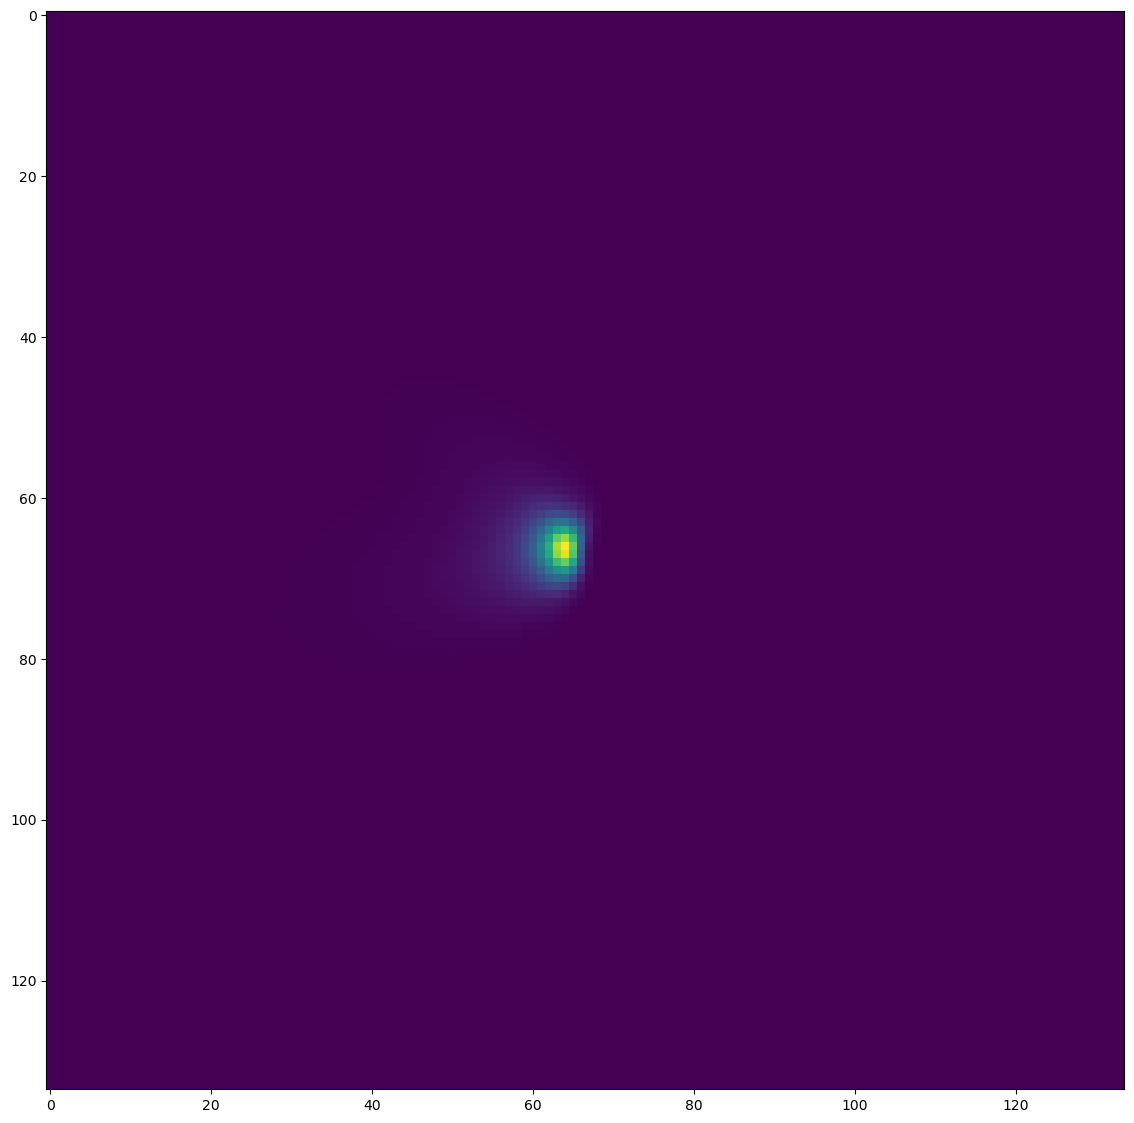

In [13]:
# Daily average
arrs = []
cnt = 0
for i in range(1,15):
    arr = src.read(i)
    if (arr == 0).all():
        continue
    else:
        cnt+=1
        arrs.append(arr)
avg_for_day = sum(arrs)/cnt

plt.figure(figsize=(14,14))
plt.imshow(avg_for_day)